In [33]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [34]:
COLS = ["CorsikaId","px","py","pz","xprime","yprime","t",
        "shower_id","prm_id","prm_energy","prm_theta","prm_phi"]

## Creating a function to do the data wrangling for all the data sets

In [35]:
def wrangle(file_path):
    df = pd.read_csv(file_path, # path
                 comment="#", # ignore comments
                 sep=' ',# separation is space
                 header=None, # no other header set
                 names=COLS, # the name of the columns
                 engine="python" 
    )

    # computing the zenith angle in radians
    df['p'] = np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2)
    df['theta_rad'] = np.arccos(df['pz'] / df['p'])  # zenith angle in radians 

    # theta radians in degrees
    df['theta'] = np.rad2deg(df['theta_rad'])


    return df


In [36]:
chyulu = wrangle("chyulu_1500_E2.shw")
chyulu.head()

,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,13,-0.030249,-0.138238,0.334440,-5244.970,2163.29,953.474,1,703,111.378,59.923,-80.833,0.363146,0.400278,22.934264
1,1,0.014500,-0.034038,0.049883,-6340.280,4478.21,951.272,1,703,111.378,59.923,-80.833,0.062106,0.638158,36.563785
2,1,-0.001223,-0.027515,0.040326,-6798.580,4482.36,950.797,1,703,111.378,59.923,-80.833,0.048834,0.599220,34.332752
3,1,0.012442,-0.047982,0.046764,-547.144,-4093.18,954.662,1,703,111.378,59.923,-80.833,0.068147,0.814515,46.668259
4,1,0.001692,-0.008911,0.005883,-523.280,-4215.28,954.584,1,703,111.378,59.923,-80.833,0.010811,0.995394,57.031847


In [37]:
lyon = wrangle("lyon_1500_E2.shw")
lyon.head()

,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,14,-0.964441,-1.745650,3.112530,2024.9700,-7633.20,951.106,1,703,51.3932,26.818,-149.160,3.696658,0.569845,32.649698
1,5,-2.123240,3.881190,2.570610,-1742.8200,-12618.10,943.269,2,703,284.3170,65.583,112.038,5.116622,1.044420,59.840842
2,6,-0.598425,0.819972,0.278704,6277.6500,-8361.58,947.422,3,703,836.8820,76.117,136.989,1.052683,1.302846,74.647560
3,6,0.023675,-0.231052,0.227444,-69.5482,-6936.94,952.224,4,703,74.4291,28.008,-62.361,0.325079,0.795878,45.600443
4,5,0.359100,-0.435764,0.812010,4375.0100,-2517.12,954.001,4,703,74.4291,28.008,-62.361,0.989042,0.607624,34.814283


In [38]:
# Comparing the unique values in both
print(f"Total showers id in chyulu: {chyulu["shower_id"].nunique()}")
print()
print(f"Total showers id in Lyon: {lyon["shower_id"].nunique()}")

Total showers id in chyulu: 2323

Total showers id in Lyon: 2366


In [39]:
# subsetting the data for only muons and resetting the index
muons_lyon = (lyon["CorsikaId"] == 6)
lyon = lyon[muons_lyon].reset_index()

muons_chyulu = (chyulu["CorsikaId"] == 6)
chyulu = chyulu[muons_chyulu].reset_index()

Comparing the graphs

In [40]:
def cos_squared_model(theta_deg, I0):
    """Cosine-power model with n fixed at 3: I(theta) = I0 * cos^2(theta)"""
    theta_rad = np.deg2rad(theta_deg)
    return I0 * np.cos(theta_rad)**2

In [41]:
# generating 100 values from 0 to 90 
theta_range = np.linspace(0, 90, 100)
 # binning the zenith angle
bins = np.arange(0, 91, 10)

Fitted I0 with n=3: 32.946 (in arbitrary units)
Fitted I0 with n=3: 33.058 (in arbitrary units)


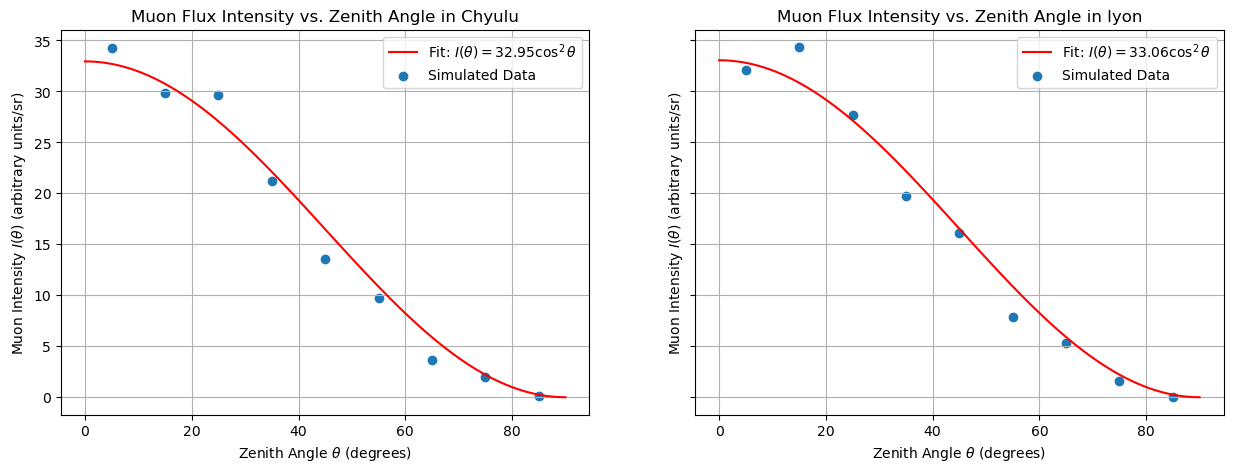

In [42]:
# creating the 3 plots in one row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True, sharex=True)

# zenith angles for chyulu
counts, bin_edges = np.histogram(chyulu['theta'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# calculating solid angle
bin_edges_rad = np.deg2rad(bin_edges) 
solid_angles = 2 * np.pi * (np.cos(bin_edges_rad[:-1]) - np.cos(bin_edges_rad[1:]))

# calculating flux intensity (input how long the simulation was running)
time = float(input("How long did the simulation run in Chyulu(s): "))
flux_intensity = counts / time / solid_angles



# fitting the binned data
try:
    popt, pcov = curve_fit(cos_squared_model, bin_centers, flux_intensity, p0=[1.0])
    I0_fit = popt[0]
    print(f"Fitted I0 with n=3: {I0_fit:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit = 1.0 # Default value if fit fails

# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit)


#plotting the curve on the same plot as 
axes[0].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[0].scatter(bin_centers, flux_intensity, label='Simulated Data')


# plotting the graph
axes[0].set_title('Muon Flux Intensity vs. Zenith Angle in Chyulu')
axes[0].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[0].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[0].legend()
axes[0].grid(True)

# ------------------------------------------------------------------------------

# zenith angles for lyon
counts_chyulu, bin_edges_chyulu = np.histogram(lyon['theta'], bins=bins)
bin_centers_chyulu = (bin_edges_chyulu[:-1] + bin_edges_chyulu[1:]) / 2.0

# calculating solid angle
bin_edges_rad_c = np.deg2rad(bin_edges_chyulu) 
solid_angles_chyulu = 2 * np.pi * (np.cos(bin_edges_rad_c[:-1]) - np.cos(bin_edges_rad_c[1:]))

# calculating flux intensity (input how long the simulation was running)
time_chyulu = float(input("How long did the simulation run in lyon(s): "))
flux_intensity_chyulu = counts_chyulu / time_chyulu / solid_angles_chyulu

# fitting the binned data
try:
    popt_chyulu, pcov_chyulu = curve_fit(cos_squared_model, bin_centers_chyulu, flux_intensity_chyulu, p0=[1.0])
    I0_fit_chyulu = popt_chyulu[0]
    print(f"Fitted I0 with n=3: {I0_fit_chyulu:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit_chyulu = 1.0 # Default value if fit fails


# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit_chyulu)


#plotting the curve on the same plot as 
axes[1].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit_chyulu:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[1].scatter(bin_centers_chyulu, flux_intensity_chyulu, label='Simulated Data')


# plotting the graph
axes[1].set_title('Muon Flux Intensity vs. Zenith Angle in lyon')
axes[1].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[1].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[1].legend()
axes[1].grid(True)

# Print all graphs
plt.tight_layout
plt.show()

The difference in Muons in Chyulu and Lyon

In [43]:
lyon.columns

Index(['index', 'CorsikaId', 'px', 'py', 'pz', 'xprime', 'yprime', 't',
       'shower_id', 'prm_id', 'prm_energy', 'prm_theta', 'prm_phi', 'p',
       'theta_rad', 'theta'],
      dtype='object')

In [44]:
print("--Lyon 1500m E2 Time 300 secs-- \n")
# groupby
top_shower_id_lyon = lyon["CorsikaId"].groupby(lyon["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_lyon = len(lyon)
print(f"Total Muon Distribution {muon_distribution_lyon} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_lyon}")

--Lyon 1500m E2 Time 300 secs-- 

Total Muon Distribution 967 

Number  of unique shower ids in 598

 Top ten shower ids in lyon 
 shower_id
1219    23
5       22
272     20
436     20
1556    19
27      15
444     10
579      9
2137     8
226      8
Name: CorsikaId, dtype: int64


In [45]:
print("--Chyulu 1500m E2 Time 300 secs-- \n")
# groupby
top_shower_id_chyulu = chyulu["CorsikaId"].groupby(chyulu["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_chyulu = len(chyulu)
print(f"Total Muon Distribution {muon_distribution_chyulu} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_chyulu}")

--Chyulu 1500m E2 Time 300 secs-- 

Total Muon Distribution 958 

Number  of unique shower ids in 598

 Top ten shower ids in lyon 
 shower_id
65      49
71      45
1253    38
77      15
1569    13
272     13
137     10
166      9
533      7
1137     6
Name: CorsikaId, dtype: int64
